In [1]:
from matplotlib import pyplot as plt
from matplotlib import animation
import ConfigModel_MCMC as CM

import networkx as nx
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns

In [2]:
def truncated_power_law(gamma, k_0, n, size=None):
    """
    Generate a sample of size *size* from a power law distribution
    with mininmum *k_0*, maximum *n*, and power *gamma*
    """
    k_0=np.float64(k_0)
    gamma=np.float64(gamma)
    n=np.float64(n)
    
    if size:
        U = rng.uniform(size=size)
    else:
        U = rng.uniform()
        
    return (
        (k_0**(1-gamma) - 
             ( k_0**(1-gamma) - n**(1-gamma) ) * U 
        )**(1/(1-gamma))
    )

In [3]:
rng = np.random.default_rng(2357111)

gamma = 2.4
k_0 = 2
n = 100
size=100

k = truncated_power_law(gamma, k_0, n, size=size).astype(int)
k.sort()
k

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,
        7,  8,  8, 10, 11, 12, 12, 15, 15, 22, 23, 39, 45, 51, 59])

In [4]:
k.mean()

5.83

In [5]:
def generate_chung_lu(k):
    n = len(k)

    k_mean = k.mean()
    # k_mean times is twice the expected number of edges
    # this will be the denominator of all edge probabilities
    m2 = k_mean * n

    # initialize adjacency matrix
    A = np.zeros((n,n),dtype=int)
    choices = rng.random(n*(n-1) // 2)
    choice_i = 0
    
    for i in range(n):
        for j in range(i+1,n):
            # no self loops
            if i == j:
                continue
                
            # compute probability of edge
            p = min(
                (k[i] * k[j] / m2,
                1))
            
            # generate edge
            if choices[choice_i] < p:
                A[i,j] = 1
                A[j,i] = 1
            
            choice_i += 1
                
    return A

A = generate_chung_lu(k)
A.sum(axis=1).mean()

5.22

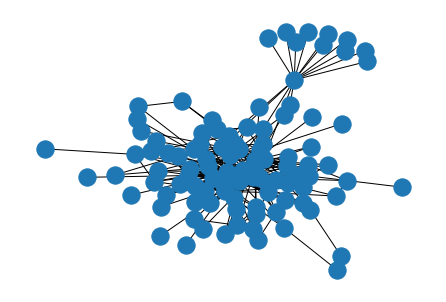

In [6]:
k = A.sum(axis=0)
disco = np.where(k==0)

for i in disco:
    j = rng.choice(n)
    A[i,j] = 1
    A[j,i] = 1
    
G = nx.convert_matrix.from_numpy_array(A)
pos = nx.spring_layout(G, seed=3113794652)

nx.draw(G,pos)

In [31]:
def run_sim(n_iter, X, eps, M, minfriends, minbad):
    Xs = [X]

    for _ in range(n_iter):
        if X.sum() < M:
            # go if enough of your friends went last week
            # whether or not you went
            X = (A.dot(X) > minfriends)
        else:
            X = (A.dot(X) > minbad)

        X += rng.uniform(size=(100,1)) < eps
        Xs.append(X)
    return np.hstack(Xs)


rng = np.random.default_rng(11235813)

eps = 0
M = 60
minfriends = 2
minbad = 5
n_iter = 1000

Xnps = []

for i in range(30):
    X = rng.uniform(size=(100,1)) < 0.3
    Xnps.append(
        run_sim(n_iter, X, eps, M, minfriends, minbad))
    print(f"Ran simulation {i}")
    
    
# skip first 50 rounds to give time to settle
attendance = [np.where(Xnp[:,50:]) for Xnp in Xnps]
ppl = [pd.Series(a[0]) for a in attendance]

cnts = pd.DataFrame(index=range(100))
for i in range(30):
    cnts[i] = ppl[i].value_counts()

    
always = (cnts==951).mean(axis=1)
sometimes = (cnts < 951).mean(axis=1)
never = cnts.isna().mean(axis=1)

cnts["Always"] = always
cnts["Sometimes"] = sometimes
cnts["Never"] = never
cnts["Degree"] = pd.Series({node:val for (node, val) in G.degree()})
cnts["Triangles"] = pd.Series(nx.triangles(G))
cnts["Eigenvec"] = pd.Series(nx.algorithms.centrality.eigenvector_centrality(G))

Ran simulation 0
Ran simulation 1
Ran simulation 2
Ran simulation 3
Ran simulation 4
Ran simulation 5
Ran simulation 6
Ran simulation 7
Ran simulation 8
Ran simulation 9
Ran simulation 10
Ran simulation 11
Ran simulation 12
Ran simulation 13
Ran simulation 14
Ran simulation 15
Ran simulation 16
Ran simulation 17
Ran simulation 18
Ran simulation 19
Ran simulation 20
Ran simulation 21
Ran simulation 22
Ran simulation 23
Ran simulation 24
Ran simulation 25
Ran simulation 26
Ran simulation 27
Ran simulation 28
Ran simulation 29


In [33]:
cnts

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,Always,Sometimes,Never,Degree,Triangles,Eigenvec
0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,5,2,0.066841
1,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,4,3,0.074934
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,1.0,3,0,0.019231
3,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,5,3,0.045728
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,1.0,2,1,0.039034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,24,59,0.280570
96,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,29,52,0.277479
97,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,29,67,0.299376
98,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,26,69,0.304366


In [34]:
cnts.Always.value_counts()

1.0    55
0.0    45
Name: Always, dtype: int64

In [35]:
cnts.Never.value_counts()

0.000000    55
1.000000    42
0.933333     3
Name: Never, dtype: int64

In [36]:
cnts.Sometimes.value_counts()

0.000000    97
0.066667     3
Name: Sometimes, dtype: int64

In [50]:
cnts[["Always", "Never", "Triangles", "Eigenvec", "Degree"]].corr()

,Always,Never,Triangles,Eigenvec,Degree
Always,1.000000,-0.999746,0.376629,0.591108,0.508536
Never,-0.999746,1.000000,-0.376654,-0.592166,-0.509407
Triangles,0.376629,-0.376654,1.000000,0.941919,0.953917
Eigenvec,0.591108,-0.592166,0.941919,1.000000,0.954822
Degree,0.508536,-0.509407,0.953917,0.954822,1.000000


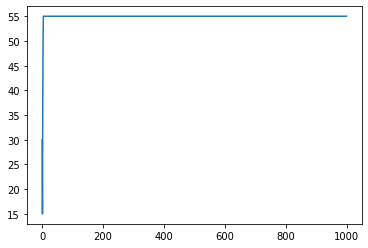

In [40]:
plt.plot(np.ravel(Xnps[0].sum(axis=0)))

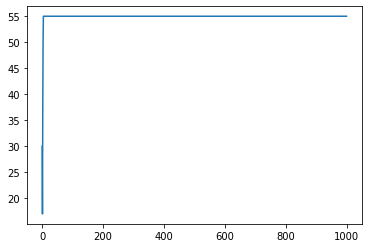

In [41]:
plt.plot(np.ravel(Xnps[1].sum(axis=0)))

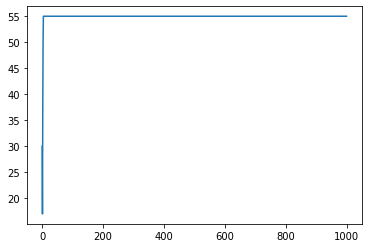

In [42]:
plt.plot(np.ravel(Xnps[1].sum(axis=0)))

<AxesSubplot:>

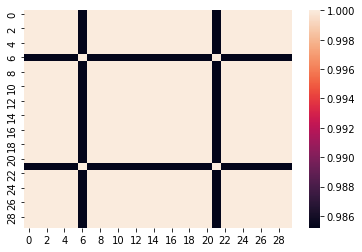

In [49]:
sns.heatmap(cnts[cnts.columns[:30]].fillna(0).corr())

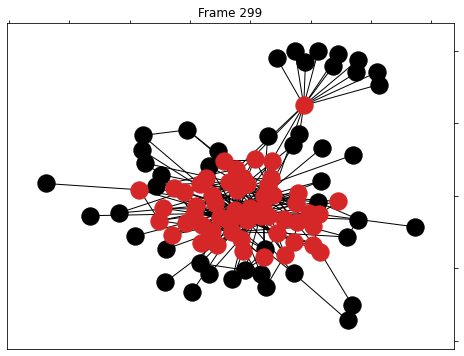

In [53]:
def animate_step(t, Xnp, pos, G, ax):
    ax.clear()

    went = np.where([Xnp[:,t]])[1]
    home = np.where([1 - Xnp[:,t]])[1]

    nx.draw_networkx_nodes(G, pos, nodelist=home, node_color="black")
    nx.draw_networkx_nodes(G, pos, nodelist=went, node_color="tab:red")

    nx.draw_networkx_edges(G, pos)

    # Set the title
    ax.set_title("Frame {}".format(t))
    
    
def make_animation(Xnp, title):
    fig, ax = plt.subplots(figsize=(8,6))
    ani = animation.FuncAnimation(fig, animate_step, frames=Xnp.shape[1], fargs=(Xnp, pos, G, ax))
    ani.save(title, writer="pillow")
    
    
make_animation(Xnps[0][:,-300:], "../images/strategy_config_model_trial_0.gif")

That was the worst animation I've ever seen!  How did it get there?

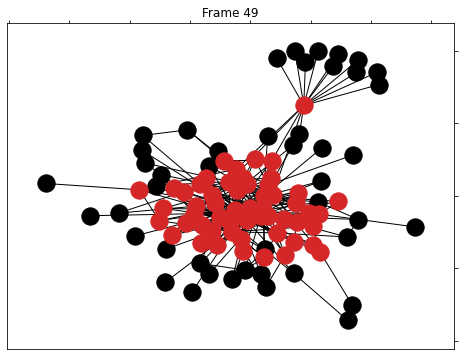

In [54]:
make_animation(Xnps[0][:,:50], "../images/strategy_config_model_trial_0_startt.gif")

So this does have a nice spreading thing until it gets everywhere it can spread.

Takeaways:

Configuration model winds up pretty much deterministic with heterogeneous degree sequence.  Maybe I should try a more homogeneous degree sequence but fuck it life is short.  Let's do some evolution!

<AxesSubplot:>

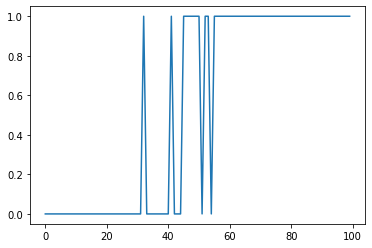

In [64]:
cnts.sort_values("Eigenvec").reset_index().Always.plot()

In [65]:
from sklearn.metrics import roc_auc_score

roc_auc_score(cnts.Always, cnts.Eigenvec)

0.987070707070707

Wow!  That's a really f\*ing good score!

In [66]:
cnts.Always.sum()

55.0

# Thoughts

It seems like the system here does converge on the optimum (maybe because it's treelike and highest degree nodes always go.  Then the results "trickle down").  Is this a true optimum?

If it were, this would mean that the Always nodes are the maximal set of nodes for which every member has at least 3 friends in the set.

In [80]:
np.where(cnts.Sometimes > 0)

(array([30, 38, 70]),)

In [81]:
G.edges(30)

EdgeDataView([(30, 24), (30, 38), (30, 70), (30, 95)])

In [82]:
G.edges(38)

EdgeDataView([(38, 30), (38, 90), (38, 97)])

In [83]:
G.edges(70)

EdgeDataView([(70, 30), (70, 96), (70, 97)])

So nodes 38 and 70 both have enough friends to go if and only if node 30 goes.  Node 30 needs either node 38 or node 70 to go before it has enough friends.

In [86]:
cnts.loc[[24,30,38,70, 90, 95, 96, 97], ["Always", "Sometimes", "Never"]]

,Always,Sometimes,Never
24,1.0,0.000000,0.000000
30,0.0,0.066667,0.933333
38,0.0,0.066667,0.933333
70,0.0,0.066667,0.933333
90,1.0,0.000000,0.000000
95,1.0,0.000000,0.000000
96,1.0,0.000000,0.000000
97,1.0,0.000000,0.000000


# Maximal Fixed Point

In [112]:
g = G.copy()

while True:
    k = g.degree()
    to_keep = [node[0] for node in k if node[1] > minfriends]
    if len(to_keep) == len(g.nodes):
        break
    g = g.subgraph(to_keep)

In [115]:
g.nodes

NodeView((0, 1, 2, 3, 9, 11, 13, 19, 20, 24, 25, 26, 28, 30, 36, 37, 38, 41, 45, 47, 53, 54, 55, 56, 57, 60, 61, 64, 65, 66, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99))

In [120]:
cnts["optimal_subgraph"] = pd.Series(range(100)).apply(lambda x: x in g.nodes)

In [122]:
cnts[["optimal_subgraph", "Always"]].corr()

,optimal_subgraph,Always
optimal_subgraph,1.00000,0.88398
Always,0.88398,1.00000


In [125]:
cnts[cnts.optimal_subgraph & (cnts.Always != 1)]

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,Always,Sometimes,Never,Degree,Triangles,Eigenvec,optimal_subgraph
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.000000,1.000000,3,0,0.019231,True
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.000000,1.000000,3,0,0.027766,True
30,NaN,NaN,NaN,NaN,NaN,NaN,475.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.066667,0.933333,4,0,0.034672,True
38,NaN,NaN,NaN,NaN,NaN,NaN,476.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.066667,0.933333,3,1,0.041972,True
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.000000,1.000000,3,0,0.039616,True
70,NaN,NaN,NaN,NaN,NaN,NaN,476.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.066667,0.933333,3,1,0.050026,True


In [126]:
G.edges(60)

EdgeDataView([(60, 26), (60, 90), (60, 96)])

In [127]:
G.edges(26)

EdgeDataView([(26, 2), (26, 60), (26, 95)])

In [128]:
G.edges(2)

EdgeDataView([(2, 26), (2, 77), (2, 92)])

Alright.  So number 2 and number 60 both need 26, 26 needs 2 and 60.  All three need to appear before any can be stable.  This depends entirely on I.C.


Another thought here...  In this case I think weekly attendance does not go over capacity ever.  What if it did?  What would dynamics look like?

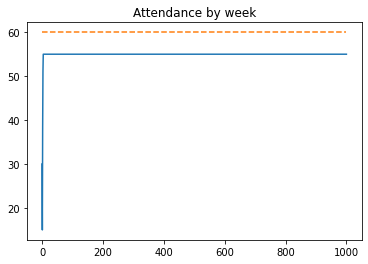

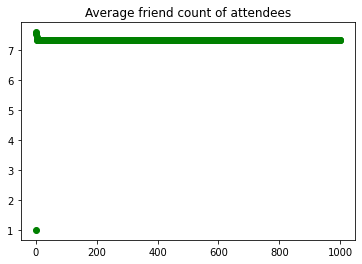

In [129]:
def plot_mask(t, friends, mask, color):
    x = np.take(t, np.where(mask))
    y = np.take(friends, np.where(mask))
    plt.scatter(x=x, y=y,color=color)
    

def summarize_run(Xnp):
    attendance = np.ravel(Xnp.sum(axis=0))
    
    plt.figure()
    plt.plot(attendance)
    plt.plot([0, n_iter], [M, M], "--")
    plt.title("Attendance by week")
    
    plt.figure()

    too_full = attendance > 60

    # col j has the number of friends of each node
    # that attended on week j
    # mask agents that did not attend
    fma = ma.masked_array(A.dot(Xnp), 1-Xnp)
    # mean friend count per week
    friends = np.ravel(fma.mean(axis=0).data)
    too_full = Xnp.sum(axis=0) > 60

    t = range(len(friends))
    plot_mask(t, friends, too_full, "r")
    plot_mask(t, friends, [~c for c in too_full], "g")
    plt.title("Average friend count of attendees")
    

summarize_run(Xnps[0])

Okay let's crank up the degrees until there is some crowding

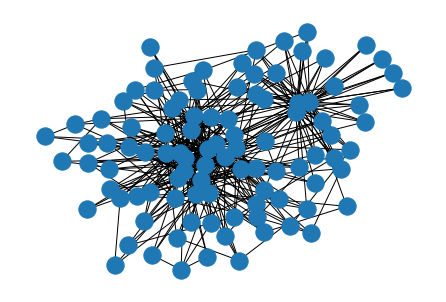

In [139]:
rng = np.random.default_rng(2357111)

gamma = 2.4
k_0 = 3
n = 100
size=100

k = truncated_power_law(gamma, k_0, n, size=size).astype(int)
k.sort()

A = generate_chung_lu(k)

# make sure all nodes are actually connected
# to at least 3.  Otherwise they are basically
# not there from the perspective of this simulation

k = A.sum(axis=0)
disco = np.where(k<3)

for i in disco:
    for j in rng.choice(n, size=3):
        A[i,j] = 1
        A[j,i] = 1

G = nx.convert_matrix.from_numpy_array(A)
pos = nx.spring_layout(G, seed=3113794652)

nx.draw(G,pos)

In [142]:
rng = np.random.default_rng(11235813)

eps = 0
M = 60
minfriends = 2
minbad = 5
n_iter = 1000

Xnps = []

for i in range(30):
    X = rng.uniform(size=(100,1)) < 0.3
    Xnps.append(
        run_sim(n_iter, X, eps, M, minfriends, minbad))
    print(f"Ran simulation {i}")
    
    
# skip first 50 rounds to give time to settle
attendance = [np.where(Xnp[:,50:]) for Xnp in Xnps]
ppl = [pd.Series(a[0]) for a in attendance]

cnts = pd.DataFrame(index=range(100))
for i in range(30):
    cnts[i] = ppl[i].value_counts()

    
always = (cnts==951).mean(axis=1)
sometimes = (cnts < 951).mean(axis=1)
never = cnts.isna().mean(axis=1)

cnts["Always"] = always
cnts["Sometimes"] = sometimes
cnts["Never"] = never
cnts["Degree"] = pd.Series({node:val for (node, val) in G.degree()})
cnts["Triangles"] = pd.Series(nx.triangles(G))
cnts["Eigenvec"] = pd.Series(nx.algorithms.centrality.eigenvector_centrality(G))

Ran simulation 0
Ran simulation 1
Ran simulation 2
Ran simulation 3
Ran simulation 4
Ran simulation 5
Ran simulation 6
Ran simulation 7
Ran simulation 8
Ran simulation 9
Ran simulation 10
Ran simulation 11
Ran simulation 12
Ran simulation 13
Ran simulation 14
Ran simulation 15
Ran simulation 16
Ran simulation 17
Ran simulation 18
Ran simulation 19
Ran simulation 20
Ran simulation 21
Ran simulation 22
Ran simulation 23
Ran simulation 24
Ran simulation 25
Ran simulation 26
Ran simulation 27
Ran simulation 28
Ran simulation 29


In [144]:
cnts

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,Always,Sometimes,Never,Degree,Triangles,Eigenvec
0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,6,5,0.060019
1,476.0,476.0,476.0,476.0,476.0,476.0,476.0,476.0,476.0,476.0,...,476.0,476.0,476.0,476.0,0.0,1.0,0.0,4,4,0.053502
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,1.0,3,1,0.018927
3,476.0,476.0,476.0,476.0,476.0,476.0,476.0,476.0,476.0,476.0,...,476.0,476.0,476.0,476.0,0.0,1.0,0.0,5,3,0.034279
4,476.0,476.0,476.0,476.0,476.0,476.0,476.0,476.0,476.0,476.0,...,476.0,476.0,476.0,476.0,0.0,1.0,0.0,5,4,0.052907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,32,115,0.252600
96,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,38,129,0.279063
97,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,43,144,0.294949
98,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,38,140,0.281239


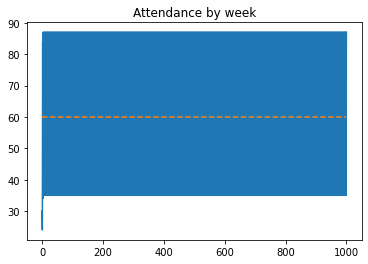

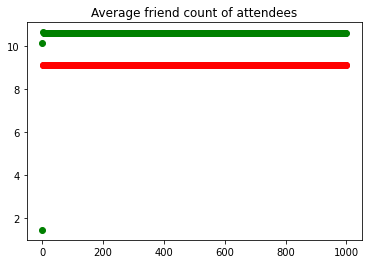

In [145]:
summarize_run(Xnps[0])

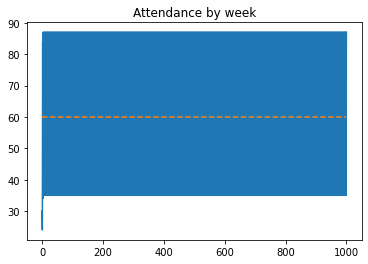

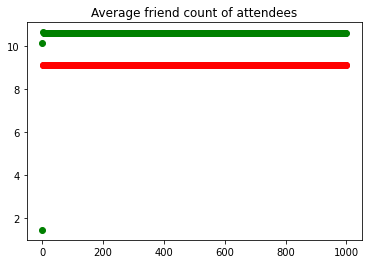

In [150]:
summarize_run(Xnps[0])

In [153]:
Xnps[0].max()

True